## Submission Information

**Submission date**: 10/10/2024

**QPM-2024-2025**: Assignment 2

**Group members**:  
- CARLUCCI Beatrice  
- GERMINO Ludovico
- GRANADOS OLVERA Daniel Rafael
- MAULI Riccardo
- NICOLETTI Edoardo

## Libraries and function

In [1]:
# Import libraries

# Data handling and financial data
import pandas as pd
import numpy as np
import yfinance as yf  # for fetching stock data

# Statistical analysis
from scipy.stats import skew, kurtosis
from scipy import stats

# Optimization
from scipy.optimize import minimize

# Visualization
import seaborn as sns
import matplotlib.pyplot as plt


In [31]:
# Function to calculate the mean returns and the Variance-Covariance matrix 

def portfolio_return(weights, returns):
    """
    Computes the return on a portfolio from constituent returns and weights
    weights are a numpy array or Nx1 matrix and returns are a numpy array or Nx1 matrix
    """
    return weights.T @ returns

def portfolio_vol(weights, covmat):
    """
    Computes the vol of a portfolio from a covariance matrix and constituent weights
    weights are a numpy array or N x 1 maxtrix and covmat is an N x N matrix
    """
    return (weights.T @ covmat @ weights)**0.5


# Constrained minimization 
def msr(riskfree_rate, er, cov, short_allowed=True):
    """
    Returns the weights of the portfolio that gives you the maximum sharpe ratio
    given the riskfree rate and expected returns and a covariance matrix
    """
    n = er.shape[0]
    init_guess = np.repeat(1/n, n)

            
    def neg_sharpe(weights, riskfree_rate, er, cov):
        """
        Returns the negative of the sharpe ratio
        of the given portfolio
        """
        r = portfolio_return(weights, er)
        vol = portfolio_vol(weights, cov)
        return -(r - riskfree_rate)/vol

    # construct the constraints
    weights_sum_to_1 = {'type': 'eq',
                        'fun': lambda weights: np.sum(weights) - 1
    }
    if short_allowed:
        weights = minimize(neg_sharpe, init_guess,
                       args=(riskfree_rate, er, cov), method='SLSQP',
                       options={'disp': False},
                       constraints=(weights_sum_to_1,),
                       )
        
    else: 
        bounds = ((0.0, 1.0),) * n 
        weights = minimize(neg_sharpe, init_guess,
                       args=(riskfree_rate, er, cov), method='SLSQP',
                       options={'disp': False},
                       constraints=(weights_sum_to_1,),
                       bounds=bounds
                          )

    return weights.x

def gmv(cov, short_allowed=True):
    """
    Returns the weights of the Global Minimum Volatility portfolio
    given a covariance matrix
    """
    n = cov.shape[0]
    return msr(0, np.repeat(1, n), cov, short_allowed)
    
def minimize_vol(target_return, er, cov):
    """
    Returns the optimal weights that achieve the target return
    given a set of expected returns and a covariance matrix
    """
    n = er.shape[0]
    init_guess = np.repeat(1/n, n)
    bounds = ((0.0, 1.0),) * n # an N-tuple of 2-tuples!
    # construct the constraints
    weights_sum_to_1 = {'type': 'eq',
                        'fun': lambda weights: np.sum(weights) - 1
    }
    return_is_target = {'type': 'eq',
                        'args': (er,),
                        'fun': lambda weights, er: target_return - portfolio_return(weights,er)
    }
    weights = minimize(portfolio_vol, init_guess,
                       args=(cov,), method='SLSQP',
                       options={'disp': False},
                       constraints=(weights_sum_to_1,return_is_target),
                       bounds=bounds)
    return weights.x

def optimal_weights(n_points, er, cov):
    """
    Returns a list of weights that represent a grid of n_points on the efficient frontier
    """
    target_rs = np.linspace(er.min(), er.max(), n_points)
    weights = [minimize_vol(target_return, er, cov) for target_return in target_rs]
    return weights

def plot_ef(n_points, er, cov, style='-', legend=True):
    """
    Plots the multi-asset efficient frontier with improved aesthetics
    """

    sns.set(style="whitegrid")
    
    weights = optimal_weights(n_points, er, cov)
    rets = [portfolio_return(w, er) for w in weights]
    vols = [portfolio_vol(w, cov) for w in weights]
    
    ef = pd.DataFrame({
        "Returns": rets, 
        "Volatility": vols
    })

    # Plot the efficient frontier
    ax = ef.plot.line(x="Volatility", y="Returns", style=style, legend=legend, color='royalblue', marker='o', linewidth=2)

    # Set plot title and labels
    ax.set_title("Efficient Frontier", fontsize=16)
    ax.set_xlabel("Portfolio Volatility (Risk)", fontsize=14)
    ax.set_ylabel("Portfolio Expected Return", fontsize=14)
    
    # Customizing the grid and axis ticks for clarity
    ax.grid(True, linestyle='--', alpha=0.7)
    ax.tick_params(axis='both', which='major', labelsize=12)

    # Display the legend if needed
    if legend:
        ax.legend(["Efficient Frontier"], loc='upper left', fontsize=12)
    
    plt.tight_layout()
    plt.show()

    return ax

def print_port (compo, names):
    for i, weight in enumerate(compo*100):
        print(f" {names[i]}: {weight:.2f}%")

# Function to apply msr over rolling window
def rolling_msr(returns, window_size, risk_free_rate,short_allowed=True):
    # Store rolling MSR weights
    rolling_weights = []

    # Iterate over each rolling window
    for start in range(len(returns) - window_size + 1):
        end = start + window_size
        window_data = returns.iloc[start:end]

        # Calculate expected returns (mean) and covariance matrix for the window
        er = window_data.mean() * 12  # Annualized mean return
        cov = window_data.cov() * 12  # Annualized covariance

        # Apply msr function to get weights
        
        weights = msr(risk_free_rate, er.values, cov.values,short_allowed)
        rolling_weights.append(weights)

    # Convert to DataFrame and align with dates
    weights_df = pd.DataFrame(rolling_weights, index=returns.index[window_size - 1:])
    return weights_df


def rolling_gmv(returns, window_size, short_allowed=True):
    # Store rolling MSR weights
    rolling_weights = []

    # Iterate over each rolling window
    for start in range(len(returns) - window_size + 1):
        end = start + window_size
        window_data = returns.iloc[start:end]

        # Calculate expected returns (mean) and covariance matrix for the window
        er = window_data.mean() * 12  # Annualized mean return
        cov = window_data.cov() * 12  # Annualized covariance

        # Apply msr function to get weights
        
        weights = gmv(cov.values, short_allowed)
        rolling_weights.append(weights)

    # Convert to DataFrame and align with dates
    weights_df = pd.DataFrame(rolling_weights, index=returns.index[window_size - 1:])
    return weights_df


def rolling_sharp(ret): 
    rolling_mean = ret.rolling(window=60).mean()

    rolling_vol = ret.rolling(window=60).std()

    rolling_sharpe = rolling_mean/rolling_vol

    return rolling_sharpe.mean()


## Question 1 of Assignment 2


**Q1.1**:

From the data that we used for the previous assignment, select the following 10 companies (these are the first 10 companies with no missing data): "MMM", "AOS", "ABT”, "ADM", "ADBE", "ADP", "AES", "AFL", "A", "AKAM"

In [3]:
tickers = ['MMM', 'AOS', 'ABT', 'ADM', 'ADBE', 'ADP', 'AES', 'AFL', 'A', 'AKAM']
start_date = "2000-01-01"
end_date = "2022-12-31"

# Download daily stock prices
df = (yf.download(tickers, start=start_date, end=end_date, interval='1mo')
              .reset_index()
              .rename(columns = {"Date": "date",
                                 "Open": "open",
                                 "High": "high",
                                 "Low": "low",
                                 "Close": "close",
                                 "Adj Close": "adjusted",
                                 "Volume": "volume"
})
)

# Reformat the dataframe in order to visualize better the data
df['date'] = pd.to_datetime(df['date'])
df.set_index(df['date'].dt.date, inplace=True)
df.drop(columns=['date'], inplace=True)


df=df['adjusted']
df.head()

[*********************100%***********************]  10 of 10 completed
C:\Users\ludov\AppData\Local\Temp\ipykernel_1308\1752515342.py:21: PerformanceWarning: dropping on a non-lexsorted multi-index without a level parameter may impact performance.
  df.drop(columns=['date'], inplace=True)


Ticker,A,ABT,ADBE,ADM,ADP,AES,AFL,AKAM,AOS,MMM
date,,,,,,,,,,
2000-01-01,40.017910,7.710966,13.668241,6.175943,22.319399,27.460970,6.645008,249.1250,2.105304,19.656385
2000-02-01,62.804317,7.852983,25.319601,5.288972,20.496206,28.724775,5.593278,261.2500,1.849409,18.514782
2000-03-01,62.879875,8.373546,27.631258,5.443054,22.701693,26.989717,6.983500,160.8125,1.929820,18.713955
2000-04-01,53.583927,9.146942,30.027845,5.245127,25.370176,30.823971,7.481634,98.8750,2.204549,18.304541
2000-05-01,44.514713,9.730956,27.948402,6.300748,25.930019,29.902899,7.922293,66.7500,2.265671,18.119648


**Q1.2**:

Choose the estimation window to be $ T_{est} = 60 $ months of monthly returns. Call this the estimation sample. Use the estimation sample to compute the following two portfolio strategies:
1. mean-variance portfolio (MVP) without constraints on the size of the weight (assume that a risk-free rate is available, with the risk-free rate equal to zero);
2. global minimum variance (GMV) portfolio without constraints on the size of the weight.

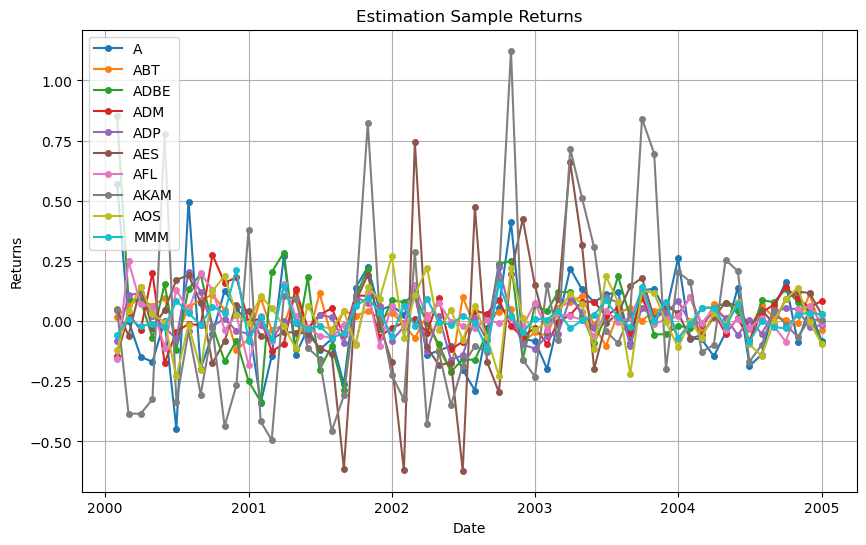

In [4]:
# Compute the monthly returns
m_ret = df.pct_change()[1:]

#Select the time window
T_est = 60
est_sample = m_ret[:T_est]

# Calculating Expected Annual return 
# Return do not scale linearly with time
ret_ann_mean = est_sample.mean() * 12 
# Volatility does scale lienarly 
ret_ann_var = est_sample.cov()* 12

# Plot the estimation sample
plt.figure(figsize=(10, 6))
plt.plot(est_sample, marker='o', linestyle='-', markersize=4)

# Add labels and title for better readability
plt.title("Estimation Sample Returns")
plt.xlabel("Date")
plt.ylabel("Returns")
plt.legend(est_sample.columns, loc="upper left")  # Add legend if multiple assets are in m_ret
plt.grid(True)
plt.show()



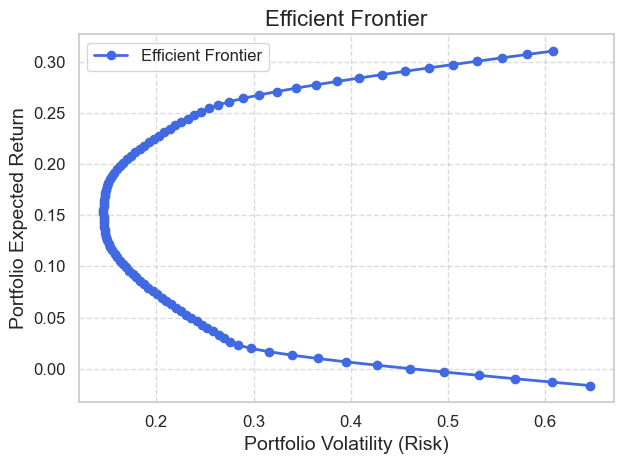

In [29]:
plot_ef(100, ret_ann_mean, ret_ann_var);

In [5]:
MVP = msr(0, ret_ann_mean, ret_ann_var)
print_port(MVP, tickers)


 MMM: -18.85%
 AOS: 21.79%
 ABT: 27.70%
 ADM: 41.17%
 ADBE: -23.52%
 ADP: 3.49%
 AES: 1.79%
 AFL: 0.09%
 A: 15.71%
 AKAM: 30.64%


In [6]:
GMV = gmv(ret_ann_var)
print_port(GMV, tickers)

 MMM: -0.25%
 AOS: 29.59%
 ABT: 3.48%
 ADM: 5.83%
 ADBE: 9.64%
 ADP: 1.96%
 AES: 7.54%
 AFL: -2.05%
 A: 10.52%
 AKAM: 33.74%


**Q1.3**:

Now use a rolling window of $ T_{est} = 60 $ months to estimate the portfolio weights for the two strategies listed above for each of the $ T − T_{est} $ months. That is, repeat the calculations of the previous question for all the dates after the first 60 months.

In [7]:
MVP_rolling_weights = rolling_msr(m_ret, 60, 0) 
MVP_rolling_weights.columns = tickers

In [8]:
MVP_rolling_weights

,MMM,AOS,ABT,ADM,ADBE,ADP,AES,AFL,A,AKAM
date,,,,,,,,,,
2005-01-01,-0.188537,0.217934,0.276973,0.411655,-0.235234,0.034948,0.017938,0.000866,0.157054,0.306402
2005-02-01,-0.190157,0.211257,0.165143,0.357500,-0.145772,0.041134,0.064393,0.006404,0.162419,0.327679
2005-03-01,-0.239699,0.202237,0.205891,0.416855,-0.177586,0.050707,-0.065440,0.018769,0.186886,0.401380
2005-04-01,-0.197401,0.285260,0.119861,0.258448,-0.192994,0.044417,0.117166,0.026917,0.172054,0.366272
2005-05-01,-0.186801,0.257572,0.138925,0.268391,-0.222714,0.035506,0.122174,0.034058,0.186436,0.366451
...,...,...,...,...,...,...,...,...,...,...
2022-08-01,0.475415,0.748411,0.253156,0.515774,0.575411,-0.089623,-0.066447,0.080987,-0.265915,-1.227168
2022-09-01,0.735896,0.817565,0.196697,0.525594,0.687632,-0.139924,-0.025195,0.064935,-0.396675,-1.466525
2022-10-01,0.695632,0.798411,0.121717,0.614841,0.580349,-0.053750,-0.022782,0.062844,-0.257467,-1.539795


In [9]:
GMV_rolling_weights = rolling_gmv(m_ret, 60, 0) 
GMV_rolling_weights.columns = tickers

In [10]:
GMV_rolling_weights

,MMM,AOS,ABT,ADM,ADBE,ADP,AES,AFL,A,AKAM
date,,,,,,,,,,
2005-01-01,-0.002501,0.295945,0.034757,0.058334,0.096391,0.019592,0.075357,-0.020503,0.105237,0.337391
2005-02-01,-0.016643,0.278926,-0.008484,0.046547,0.135545,0.016728,0.102735,-0.012756,0.114969,0.342433
2005-03-01,-0.005917,0.275440,-0.017216,0.029225,0.150046,0.010931,0.159446,-0.016649,0.110890,0.303803
2005-04-01,-0.015204,0.285338,-0.018140,-0.005795,0.191352,0.011215,0.171772,-0.021626,0.126420,0.274669
2005-05-01,-0.019146,0.285492,-0.015818,0.011776,0.190220,0.010482,0.175060,-0.022442,0.127317,0.257059
...,...,...,...,...,...,...,...,...,...,...
2022-08-01,0.040794,0.368645,0.034268,0.241916,0.260115,-0.022285,0.075719,0.192815,-0.171593,-0.020393
2022-09-01,0.081925,0.382720,-0.025191,0.229583,0.281992,-0.031653,0.085567,0.200137,-0.190126,-0.014954
2022-10-01,0.083942,0.428627,-0.027543,0.202311,0.315188,-0.043128,0.077676,0.198997,-0.203600,-0.032471


**Q1.4**:

Use the time-series of portfolios weights for each of the two portfolio strategies, to compute the out-of-sample portfolio returns. That is, for each of the two portfolio strategies that you estimate at each date $ t $, compute its out-of-sample return in month $ t + 1 $.

In [11]:
MVP_out_of_sample_returns = (MVP_rolling_weights.shift(1)[1:] * m_ret[60:]).sum(axis=1)

In [12]:
MVP_out_of_sample_returns.name = "Returns Mean Variance Portfolio"
MVP_out_of_sample_returns

date
2005-02-01   -0.051160
2005-03-01    0.053101
2005-04-01   -0.096853
2005-05-01    0.121610
2005-06-01    0.006756
                ...   
2022-08-01   -0.094587
2022-09-01   -0.200805
2022-10-01    0.221793
2022-11-01    0.009475
2022-12-01    0.084246
Name: Returns Mean Variance Portfolio, Length: 215, dtype: float64

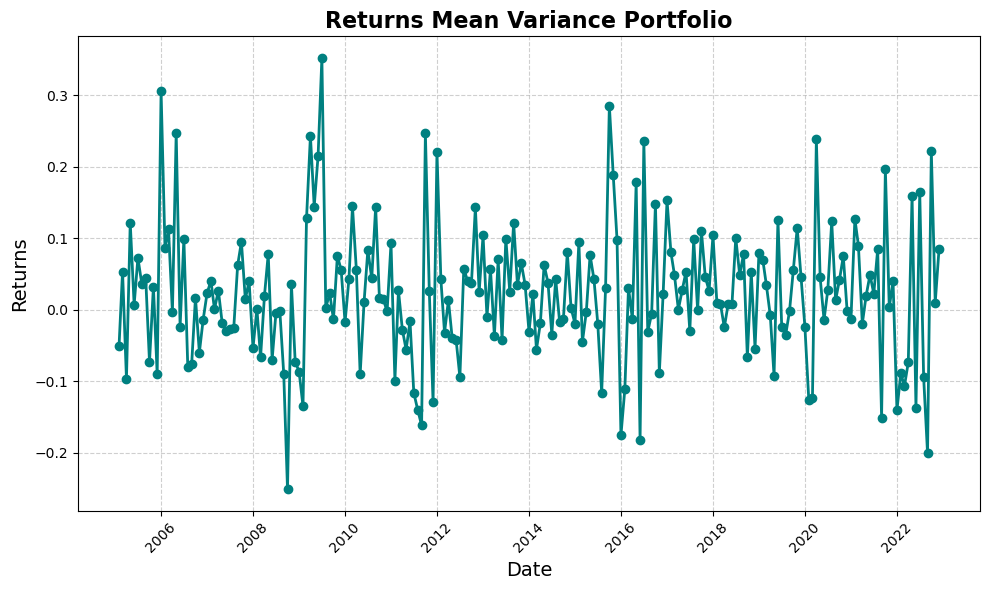

In [13]:
# Plotting the series
plt.figure(figsize=(10, 6))
plt.plot(MVP_out_of_sample_returns.index, MVP_out_of_sample_returns.values, color='teal', linewidth=2, marker='o', markersize=6)

# Plot
plt.title(MVP_out_of_sample_returns.name, fontsize=16, fontweight='bold')
plt.xlabel('Date', fontsize=14)
plt.ylabel('Returns', fontsize=14)
plt.grid(True, linestyle='--', alpha=0.6)
plt.xticks(rotation=45)
plt.tight_layout()

plt.show()

In [14]:
GMV_out_of_sample_returns = (GMV_rolling_weights.shift(1)[1:] * m_ret[60:]).sum(axis=1)
GMV_out_of_sample_returns.name = "Returns Global Minimum Variance"

In [15]:
GMV_out_of_sample_returns

date
2005-02-01   -0.028449
2005-03-01    0.083690
2005-04-01   -0.062804
2005-05-01    0.110424
2005-06-01   -0.072366
                ...   
2022-08-01   -0.027326
2022-09-01   -0.150278
2022-10-01    0.166276
2022-11-01    0.072493
2022-12-01   -0.032153
Name: Returns Global Minimum Variance, Length: 215, dtype: float64

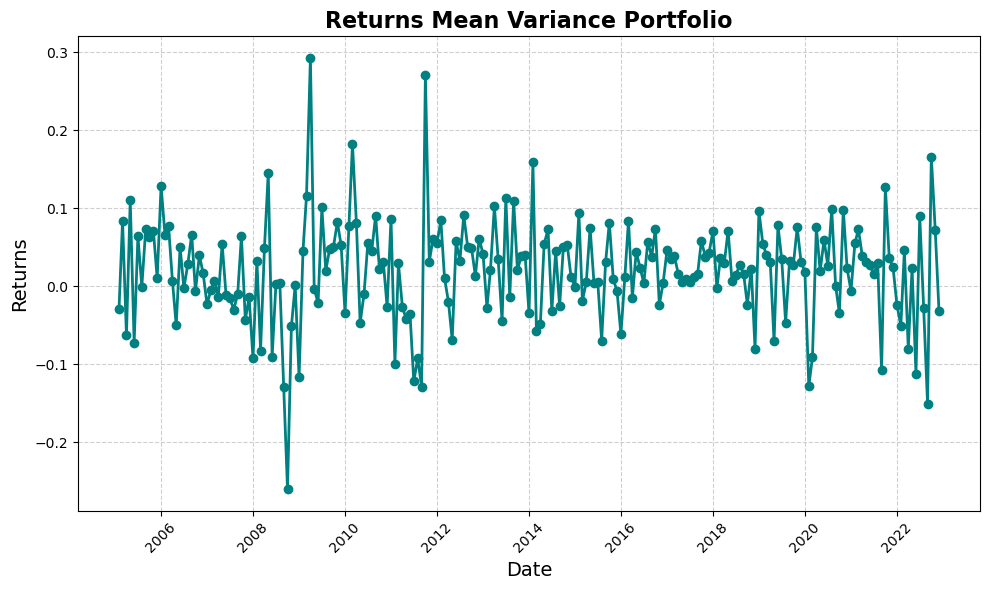

In [16]:
# Plotting the series
plt.figure(figsize=(10, 6))
plt.plot(GMV_out_of_sample_returns.index, GMV_out_of_sample_returns.values, color='teal', linewidth=2, marker='o', markersize=6)

# Plot
plt.title(MVP_out_of_sample_returns.name, fontsize=16, fontweight='bold')
plt.xlabel('Date', fontsize=14)
plt.ylabel('Returns', fontsize=14)
plt.grid(True, linestyle='--', alpha=0.6)
plt.xticks(rotation=45)
plt.tight_layout()

plt.show()

**Q1.5**:

Now, compute the Sharpe ratio of the out-of-sample returns for the two portfolio strategies. Which strategy has the higher Sharpe ratio?

In [17]:
SR_MVP = rolling_sharp(MVP_out_of_sample_returns)

In [18]:
SR_GMV = rolling_sharp(GMV_out_of_sample_returns)

In [19]:
print(f"Rolling Sharpe Ratio for MVP Portfolio: \n{SR_MVP:f}\n")
print(f"Rolling Sharpe Ratio for GMV Portfolio: \n{SR_GMV:f}\n")

Rolling Sharpe Ratio for MVP Portfolio: 
0.270383

Rolling Sharpe Ratio for GMV Portfolio: 
0.373467



## Question 2 of Assignment 2


**Q2.1**:

Using the estimation window of $ T_{est} = 60 $ months of monthly returns, now compute the following two portfolio strategies:
1. mean-variance portfolio with nonnegativity constraints on the weights (when a risk-free rate is available, and set this rate to 0); we will refer to this portfolio as "MVP-C".
2. global minimum variance (GMV) portfolio with nonnegativity constraints; we will refer to this portfolio as "GMV-C".

In [22]:
MVP_C = msr(0, ret_ann_mean, ret_ann_var, short_allowed=False)
print_port(MVP_C, tickers)


 MMM: 0.00%
 AOS: 19.65%
 ABT: 11.62%
 ADM: 24.93%
 ADBE: 0.00%
 ADP: 0.11%
 AES: 10.04%
 AFL: 0.00%
 A: 9.86%
 AKAM: 23.79%


In [27]:
GMV_C = gmv(ret_ann_var, short_allowed=False)

print_port(GMV_C, tickers)

 MMM: 0.00%
 AOS: 28.73%
 ABT: 2.68%
 ADM: 6.08%
 ADBE: 8.92%
 ADP: 0.86%
 AES: 9.95%
 AFL: 0.00%
 A: 10.06%
 AKAM: 32.71%


**Q2.2**:

Now use a rolling window of $ T_{est} = 60 $ months to estimate the portfolio weights for the two strategies listed above for each of the $ T − T_{est} $ months. That is, repeat the calculations of the previous question for all the dates after the first 60 months.

In [49]:
MVP_C_rolling_weights = rolling_msr(m_ret, 60, 0, short_allowed=False) 
MVP_C_rolling_weights.columns = tickers

In [50]:
MVP_C_rolling_weights

,MMM,AOS,ABT,ADM,ADBE,ADP,AES,AFL,A,AKAM
date,,,,,,,,,,
2005-01-01,8.577362e-15,0.196485,1.162145e-01,0.249298,3.737160e-15,0.001053,1.004077e-01,4.829832e-15,9.863775e-02,2.379048e-01
2005-02-01,0.000000e+00,0.211115,8.977190e-03,0.223978,0.000000e+00,0.017591,1.567676e-01,0.000000e+00,1.037618e-01,2.778090e-01
2005-03-01,5.373632e-15,0.207947,2.022117e-02,0.241198,1.021097e-15,0.021680,7.202087e-02,1.707520e-15,1.168284e-01,3.201041e-01
2005-04-01,0.000000e+00,0.256207,0.000000e+00,0.142716,0.000000e+00,0.018914,1.732397e-01,0.000000e+00,1.142953e-01,2.946284e-01
2005-05-01,3.114562e-15,0.235420,2.201845e-03,0.129812,1.114866e-15,0.016503,1.679185e-01,0.000000e+00,1.335289e-01,3.146158e-01
...,...,...,...,...,...,...,...,...,...,...
2022-08-01,0.000000e+00,0.257655,5.563996e-02,0.246278,2.358836e-01,0.089021,1.924633e-16,1.155222e-01,8.777665e-16,3.738798e-16
2022-09-01,0.000000e+00,0.299536,1.072524e-16,0.251047,2.880572e-01,0.086706,0.000000e+00,7.465399e-02,3.807744e-16,0.000000e+00
2022-10-01,1.271150e-16,0.296402,1.377666e-16,0.317900,2.230320e-01,0.116017,8.909840e-17,4.664974e-02,0.000000e+00,3.635781e-16


In [41]:
GMV_C_rolling_weights = rolling_gmv(m_ret, 60, short_allowed=False) 
GMV_C_rolling_weights.columns = tickers

In [42]:
GMV_C_rolling_weights

,MMM,AOS,ABT,ADM,ADBE,ADP,AES,AFL,A,AKAM
date,,,,,,,,,,
2005-01-01,0.000000e+00,0.287288,2.676554e-02,0.060763,0.089249,8.623941e-03,0.099528,5.798462e-14,1.006374e-01,3.271455e-01
2005-02-01,1.951977e-15,0.273209,0.000000e+00,0.057687,0.108385,7.678095e-03,0.122245,1.736531e-14,1.059881e-01,3.248079e-01
2005-03-01,0.000000e+00,0.264771,0.000000e+00,0.046757,0.123703,5.392721e-04,0.173457,0.000000e+00,1.047902e-01,2.859820e-01
2005-04-01,8.826528e-15,0.274744,2.183364e-14,0.016906,0.145562,0.000000e+00,0.193058,2.273688e-13,1.126083e-01,2.571214e-01
2005-05-01,8.446289e-15,0.276811,1.176885e-14,0.028492,0.141402,0.000000e+00,0.196594,8.463803e-14,1.106819e-01,2.460200e-01
...,...,...,...,...,...,...,...,...,...,...
2022-08-01,0.000000e+00,0.308804,3.013090e-16,0.200133,0.199269,2.078877e-02,0.064441,2.065641e-01,0.000000e+00,0.000000e+00
2022-09-01,1.407045e-16,0.328479,1.863336e-16,0.202486,0.203535,0.000000e+00,0.080277,1.852232e-01,2.491301e-16,1.963680e-17
2022-10-01,8.090658e-17,0.368122,4.948878e-16,0.162946,0.223334,0.000000e+00,0.063600,1.819986e-01,9.134814e-16,8.465529e-17


**Q2.3**:

Use the time-series of portfolios weights for each of the two portfolio strategies, to compute the out-of-sample portfolio returns. That is, for each of the two portfolio strategies that you estimate at each date $ t $, compute its out-of-sample return in month $ t + 1$.

In [51]:
MVP_C_out_of_sample_returns = (MVP_C_rolling_weights.shift(1)[1:] * m_ret[60:]).sum(axis=1)
MVP_C_out_of_sample_returns.columns = tickers

In [52]:
MVP_C_out_of_sample_returns.name = "Returns Mean Variance Portfolio (No Short Sell)"
MVP_C_out_of_sample_returns

date
2005-02-01   -0.013064
2005-03-01    0.059243
2005-04-01   -0.098966
2005-05-01    0.102988
2005-06-01   -0.034039
                ...   
2022-08-01   -0.037497
2022-09-01   -0.133152
2022-10-01    0.153315
2022-11-01    0.070029
2022-12-01   -0.047724
Name: Returns Mean Variance Portfolio (No Short Sell), Length: 215, dtype: float64

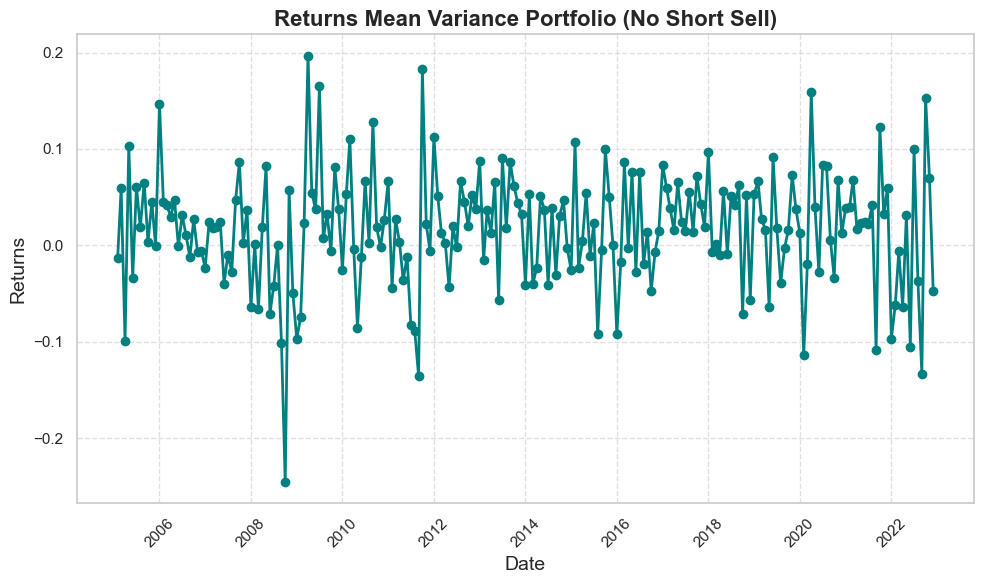

In [53]:
# Plotting the series
plt.figure(figsize=(10, 6))
plt.plot(MVP_C_out_of_sample_returns.index, MVP_C_out_of_sample_returns.values, color='teal', linewidth=2, marker='o', markersize=6)

# Plot
plt.title(MVP_C_out_of_sample_returns.name, fontsize=16, fontweight='bold')
plt.xlabel('Date', fontsize=14)
plt.ylabel('Returns', fontsize=14)
plt.grid(True, linestyle='--', alpha=0.6)
plt.xticks(rotation=45)
plt.tight_layout()

plt.show()

In [43]:
GMV_C_out_of_sample_returns = (GMV_C_rolling_weights.shift(1)[1:] * m_ret[60:]).sum(axis=1)
GMV_C_out_of_sample_returns.columns = tickers

In [44]:
GMV_C_out_of_sample_returns.name = "Returns Mean Variance Portfolio (No Short Sell)"
GMV_C_out_of_sample_returns

date
2005-02-01   -0.023695
2005-03-01    0.078312
2005-04-01   -0.060794
2005-05-01    0.099556
2005-06-01   -0.058806
                ...   
2022-08-01   -0.020096
2022-09-01   -0.130256
2022-10-01    0.157562
2022-11-01    0.088027
2022-12-01   -0.033753
Name: Returns Mean Variance Portfolio (No Short sell), Length: 215, dtype: float64

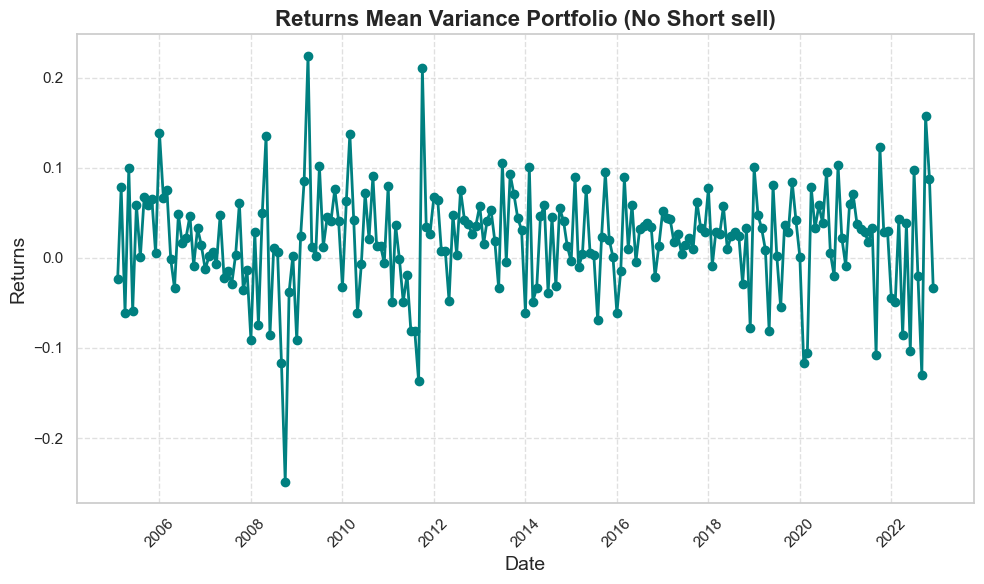

In [46]:
# Plotting the series
plt.figure(figsize=(10, 6))
plt.plot(GMV_C_out_of_sample_returns.index, GMV_C_out_of_sample_returns.values, color='teal', linewidth=2, marker='o', markersize=6)

# Plot
plt.title(GMV_C_out_of_sample_returns.name, fontsize=16, fontweight='bold')
plt.xlabel('Date', fontsize=14)
plt.ylabel('Returns', fontsize=14)
plt.grid(True, linestyle='--', alpha=0.6)
plt.xticks(rotation=45)
plt.tight_layout()

plt.show()

**Q2.4**:

Now, compute the Sharpe ratio of the out-of-sample returns for the two portfolio strategies, "MVP-C"  and "GMV-C". Which strategy has the higher Sharpe ratio?

In [54]:
SR_MVP_C = rolling_sharp(MVP_C_out_of_sample_returns)

In [55]:
SR_GMV_C = rolling_sharp(GMV_C_out_of_sample_returns)

In [57]:
print(f"Rolling Sharpe Ratio for MVP with constrains Portfolio: \n{SR_MVP_C:f}\n")
print(f"Rolling Sharpe Ratio for GMV with constrains Portfolio: \n{SR_GMV_C:f}\n")

Rolling Sharpe Ratio for MVP with constrains Portfolio: 
0.324038

Rolling Sharpe Ratio for GMV with constrains Portfolio: 
0.387045



**Q2.5**:

Finally, out of the four strategies you have considered in the two questions, "MVP", "GMV", "MVP" and "GMV-C", which strategy has the highest Sharpe ratio. Why do you think this strategy performs the best?

In [59]:
print(f"Rolling Sharpe Ratio for MVP Portfolio: \n{SR_MVP:f}\n")
print(f"Rolling Sharpe Ratio for GMV Portfolio: \n{SR_GMV:f}\n")
print(f"Rolling Sharpe Ratio for MVP with constrains Portfolio: \n{SR_MVP_C:f}\n")
print(f"Rolling Sharpe Ratio for GMV with constrains Portfolio: \n{SR_GMV_C:f}\n")

Rolling Sharpe Ratio for MVP Portfolio: 
0.270383

Rolling Sharpe Ratio for GMV Portfolio: 
0.373467

Rolling Sharpe Ratio for MVP with constrains Portfolio: 
0.324038

Rolling Sharpe Ratio for GMV with constrains Portfolio: 
0.387045

